In [1]:
from imutils import face_utils
import numpy as np
import argparse
import imutils
import dlib
import glob
import os
from PIL import Image
from matplotlib import pyplot as plt
import cv2
import imgaug.augmenters as iaa
import scipy.io
import tensorflow as tf
import seaborn as sns

In [2]:
data_dir = "MPIIGaze/Data/Normalized"
list_ds = tf.data.Dataset.list_files(str(data_dir+'/*/*'))
data = []
labels = []
for strs in list_ds:
    mat = scipy.io.loadmat(strs.numpy())
    for picnum in range(len(mat['data'][0][0][0][0][0][1])):
        for i in range(2):
            img = mat['data'][0][0][i][0][0][1][picnum]
            img = Image.fromarray(img)
            img = img.resize((20, 12))
            img = img.resize((60, 36))
            img = np.array(img)
            img = img.reshape((36, 60, 1))
            data.append(img / 255) 
            labels.append(mat['data'][0][0][i][0][0][0][picnum])

mat['data'][0][0][0][0][0][0] some 3d vector <br>
mat['data'][0][0][0][0][0][1] eyes maybe <br>
mat['data'][0][0][0][0][0][2] some 3d vector


mat['data'][0][0][eye_num] eye num

In [3]:
"""data = tf.data.Dataset.from_tensor_slices(data)
labels = tf.data.Dataset.from_tensor_slices(labels)"""
data = np.array(data)
labels = np.array(labels)


In [4]:
import copy
from functools import partial
def get_pixel(tens, a, b, c, d,
              width=0.54, heigth=0.30375,
              pixel_width=1920, pixel_heigth=1080):
    [x, y, z] = tens
    k = -d / (a * x + b * y + c * z)
    x = k * x
    y = k * y
    z = k * z
    pixel_x = x / width * pixel_width
    pixel_y = y / heigth * pixel_heigth
    return pixel_x, pixel_y
pxlf = partial(get_pixel,a=0, b=0, c=1, d=-1)
xlist, ylist = [], []
for img in labels:
    x, y = pxlf(img)
    xlist.append(x)
    ylist.append(y)

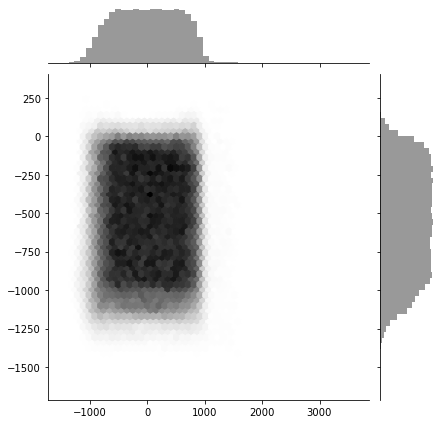

In [5]:
sns.jointplot(x=xlist, y=ylist, kind="hex", color="k");

In [6]:
"""dataset = tf.data.Dataset.zip((data, labels))"""
NUM_BATCHES = 32
def generatorr(data, labels):
    order_list = np.arange(len(data) )
    order_list = np.random.permutation(order_list)
    affine = iaa.Affine(scale=(0.9,1.1), translate_percent=(-0.1,0.1),)
    noise = iaa.Sequential([
        iaa.Sometimes(then_list=iaa.AdditiveGaussianNoise(scale=(0, 0.1), per_channel=True)),
      #  iaa.Sometimes(then_list=iaa.AdditivePoissonNoise(lam=(0, 1), per_channel=True)),
        #iaa.Sometimes(then_list=iaa.SaltAndPepper(p=(0,0.1)))
    ])
    blur = iaa.OneOf([
        iaa.GaussianBlur(sigma=(0.0, 1.0)),
        iaa.MotionBlur(k=3, angle=(-180, 0))
    ])
    augmentation = iaa.Sequential([blur, noise, affine])
    augmented_list = []
    augmented_lavels = []

    for i in range(len(order_list) - 4 * NUM_BATCHES):
        if len(augmented_list) == 0:
            augmented_list = [np.ndarray.astype(data[order_list[i+j]], dtype=np.float32) for j in range(NUM_BATCHES)]

            augmented_labels = [labels[order_list[i+j]] for j in range(NUM_BATCHES)]
            
            augmented_list = augmentation.augment_images(augmented_list)
            
        pic = augmented_list[0]
        augmented_list = augmented_list[1:]
        label = augmented_labels[0]
        augmented_labels = augmented_labels[1:]
        
        yield pic, label
test_data = data[:int(len(data)*0.2)]
train_data = data[int(len(data)/5):]
test_labels = labels[:int(len(data)/5)]
train_labels = labels[int(len(data)/5):]
import functools
train_dataset = tf.data.Dataset.from_generator(functools.partial(generatorr, train_data, train_labels),
                                              output_types=(tf.float32, tf.float32),
                                               output_shapes=((36, 60, 1), (3))
                                             )
test_dataset = tf.data.Dataset.from_generator(functools.partial(generatorr, test_data, test_labels),
                                              output_types=(tf.float32, tf.float32),
                                               output_shapes=((36, 60, 1), (3))
                                             )
train_dataset = train_dataset.batch(NUM_BATCHES,drop_remainder=True)
test_dataset = test_dataset.batch(NUM_BATCHES,drop_remainder=True)

In [7]:
import math
@tf.function
def get_pixel(tens, a, b, c, d, 
              width=0.54, heigth=0.30375, 
              pixel_width=1920, pixel_heigth=1080):
    """k = -d / (a * x + b * y + c * z)
    print(x[0].item())
    x = k * x
    y = k * y
    z = k * z
    pixel_x = x / width * pixel_width
    pixel_y = y / heigth * pixel_heigth
    return pixel_x, pixel_y """
    fl = np.array([a, b, c])
    ratios = np.array([width * pixel_width, heigth * pixel_heigth])
    bottom = tf.math.reduce_sum(tens * fl, 1)
    k = d / (tf.math.reduce_sum(tens * fl, 1))
    k = tf.convert_to_tensor([k, k, k])
    k = tf.transpose(k)
    tens = tens * k
    tens = tens[:, 0:2]
    tens = tens * ratios
    return tens
kek = tf.convert_to_tensor([1e-8 for i in range(NUM_BATCHES)], dtype=tf.float32)

@tf.function
def generic_pixel_loss(y_true, y_pred, pixel_func, sample_weight=0):
    y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
    pix_pred = pixel_func(y_pred)
    pix_true = pixel_func(y_true)
    return tf.reduce_mean(tf.sqrt(tf.square(pix_pred - pix_true)))

from functools import partial
pixel_loss = partial(generic_pixel_loss, pixel_func=
                    partial(get_pixel,
                           a=0, b=0, c=1, d=-1))

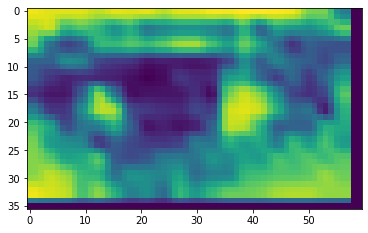

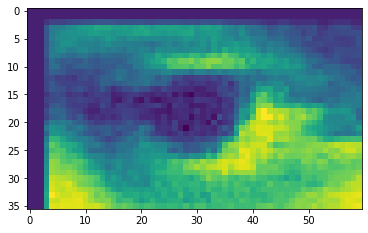

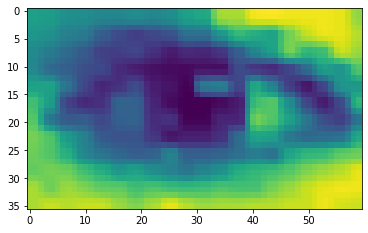

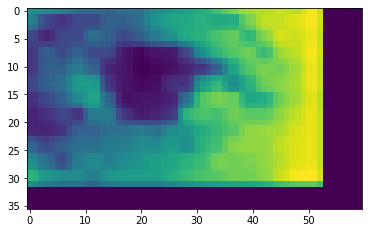

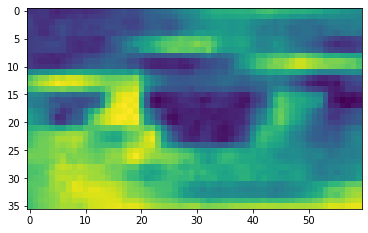

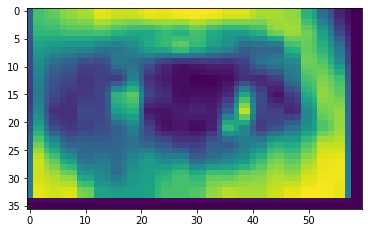

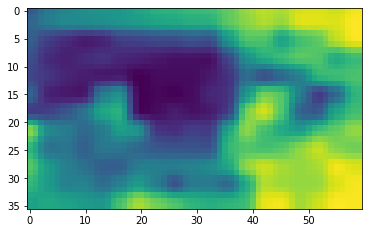

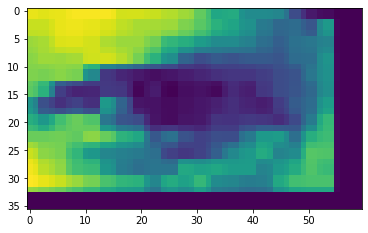

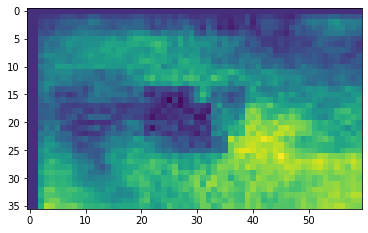

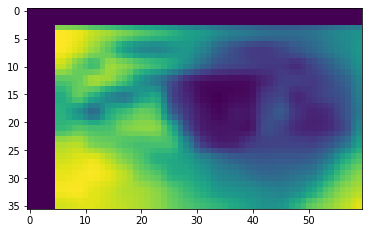

In [8]:
for a, b in train_dataset.take(10):
    plt.imshow(np.array(a[0]).reshape(36, 60))
    plt.show()

In [8]:
import sys
sys.path.append("watcher/")
import model as model_generator
import importlib
importlib.reload(model_generator)
model = model_generator.get_model()



"""with tf.GradientTape() as tape:
    values = model(pics[:32], training=True)
    loss_value = pixel_loss(values, coords_1[0:32])
    print(loss_value)"""

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 36, 60, 1)]       0         
_________________________________________________________________
sequential (Sequential)      (None, 1500)              904650    
_________________________________________________________________
dense_1 (Dense)              (None, 1500)              2251500   
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 4503      
Total params: 3,160,653
Trainable params: 3,160,413
Non-trainable params: 240
_________________________________________________________________


'with tf.GradientTape() as tape:\n    values = model(pics[:32], training=True)\n    loss_value = pixel_loss(values, coords_1[0:32])\n    print(loss_value)'

In [ ]:
class my_callback(tf.keras.callbacks.Callback):
    def on_batch_end(self, batch, logs={}):
        if(tf.math.is_nan(logs['loss'])):
            tf.print(batch)
            self.model.stop_training = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(clipnorm=1.), 
    loss="MSE")#pixel_loss)
NUM_EPOCHS = 10
clb = my_callback()
model.fit(train_dataset,
          epochs=NUM_EPOCHS,
          validation_data=test_dataset,
          validation_steps=int(len(data) / 5 / NUM_EPOCHS / NUM_BATCHES) - 2,
          callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath="checkpoint_path/",
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_best_only=True),
                    clb]
         )

Epoch 1/10
  10678/Unknown - 819s 77ms/step - loss: 0.0018
Epoch 00001: val_loss improved from inf to 0.00176, saving model to checkpoint_path/
10678/10678 [==============================] - 838s 78ms/step - loss: 0.0018 - val_loss: 0.0000e+00
Epoch 2/10
10677/10678 [============================>.] - ETA: 0s - loss: 0.0017
Epoch 00002: val_loss did not improve from 0.00176
10678/10678 [==============================] - 843s 79ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 3/10
10677/10678 [============================>.] - ETA: 0s - loss: 0.0016
Epoch 00003: val_loss improved from 0.00176 to 0.00163, saving model to checkpoint_path/
10678/10678 [==============================] - 831s 78ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 4/10
10677/10678 [============================>.] - ETA: 0s - loss: 0.0016
Epoch 00004: val_loss did not improve from 0.00163
10678/10678 [==============================] - 822s 77ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 5/10
10677/10678 [==========

In [ ]:
print(train_data.dtype)
predictions = model.predict(train_data[:32])
print(type(predictions))
print(pixel_loss(predictions, tf.cast(train_labels[:32], dtype=tf.float32)))
for i in range(32):
    plt.xlabel(F'{-1*predictions[i] / np.linalg.norm(predictions[i])}\n{train_labels[i]}')
    plt.imshow(train_data[i].reshape(36, 60))
    plt.show()

In [11]:
with tf.GradientTape() as tame:
    nums = model(train_data[:10], training=False)
    print(model.weights)
model.load_weights("checkpoint_path/")

[<tf.Variable 'conv2d/kernel:0' shape=(3, 3, 1, 60) dtype=float32, numpy=
array([[[[ 1.42510775e-02, -1.59933388e-01, -8.95301998e-02,
          -2.77515501e-01, -9.83766690e-02, -3.95777337e-02,
           1.09745460e-02,  9.49820951e-02,  3.45982105e-01,
          -3.15298117e-03, -2.00288109e-02, -7.14078993e-02,
          -2.42984846e-01, -1.62041597e-02, -2.78585553e-01,
          -7.94825424e-03, -7.08760992e-02, -1.71764791e-02,
          -4.66219056e-03,  1.07351290e-02, -1.84274185e-02,
          -5.68845421e-02,  2.13209763e-01,  2.36203410e-02,
           1.71210356e-02, -8.06692317e-02,  3.58823570e-04,
          -2.28097171e-01, -9.77124199e-02, -4.38154489e-02,
           1.27951764e-02, -1.93388119e-01, -7.38117425e-03,
          -1.12015963e-01,  1.62097111e-01, -2.99933374e-01,
          -1.69199511e-01, -8.15696176e-03, -1.93481088e-01,
           4.41022702e-02,  1.38797332e-02, -8.18031728e-02,
           3.55091035e-01, -1.80957001e-02, -3.02022994e-01,
           